In [47]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D,Wraparound1D,periodic_padding,CustomCallback
from AnticipatoryCA import AnticipatoryCA
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

def set_seed():
    SEED =3
    os.environ['PYTHONHASHSEED']=str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.config.threading.set_inter_op_parallelism_threads(1)
num_filters=1
num_classes = 2
gridsize=10
loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                                            tf.reshape(y, shape=(-1, num_classes)) ,from_logits=True)
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]
x_values = [[int(bit) for bit in seq] for seq in x_values]
def get_model():

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(gridsize, MEMORY_CONSTANT, 1)))
    model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=MEMORY_CONSTANT, padding='valid',
                                 kernel_initializer=tf.keras.initializers.Ones(),
                                 activation="relu"))
    model.add(tf.keras.layers.Reshape((gridsize, 1)))
    model.add(tf.keras.layers.Dense(units=num_classes, activation="softmax"))

    model.add(Wraparound1D(padding=1))

    model.add(tf.keras.layers.Conv1D(gridsize, 3, activation='relu', padding='valid', trainable=True))
    model.add(tf.keras.layers.Conv1D(gridsize, 1, activation='relu', padding='same'))

    model.add(tf.keras.layers.Dense(units=num_classes, activation="softmax",
                                bias_initializer=tf.keras.initializers.Zeros()))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    
    return model
def split_dataset(x,y):
        split_ratio=0.25
        split_point_x = int(len(x) * split_ratio)
        split_point_y = int(len(y) * split_ratio)

        x_test = x[:split_point_x]
        y_test = y[:split_point_y]
        x_train = x[split_point_x:]
        y_train = y[split_point_y:]
        split_ratio = 0.5

        split_point_x = int(len(x_test) * split_ratio)
        split_point_y = int(len(y_test) * split_ratio)


        x_val = x_test[:split_point_x]
        y_val = y_test[:split_point_x]
        x_test = x_test[split_point_x:]
        y_test = y_test[split_point_x:]
        return  (x_train,y_train,x_val,y_val,x_test,y_test)
RULE_NUMBER=30

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Generation

In [48]:
set_seed()

MEMORY_CONSTANT=1
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=MEMORY_CONSTANT)

ca.set_rule_number(RULE_NUMBER)
sequences= np.array(ca.generate_training_data_sequences(x_values,sequence_length=sequence_length))


 

np.random.shuffle(sequences)
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
y_sequence=sequences[:,MEMORY_CONSTANT*2]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
x_train = x_sequence
y_train_full= Y_val_onehot
  

                                             
print("Data generated") 

Data generated


In [49]:

print(x_train.shape)
x_train=x_train.reshape(-1,10,1)

x_train,y_train,x_val,y_val,x_test,y_test=split_dataset(x_train,y_train_full)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape, "x_val shape:", x_val.shape, "y_val shape:", y_val.shape,
      "x_test shape:", x_test.shape, "y_test shape:", y_test.shape)


(1024, 1, 10)
x_train shape: (768, 10, 1)
y_train shape: (768, 10, 2)
x_val shape: (128, 10, 1)
y_val shape: (128, 10, 2)
x_test shape: (128, 10, 1)
y_test shape: (128, 10, 2)


In [11]:
x_train.shape

(768, 10, 1)

# Training heuristics  

## Removed layers



In [12]:
memory_horizon=MEMORY_CONSTANT# is equal to 1
heuristic = tf.keras.Sequential()
heuristic.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
heuristic.add(Wraparound1D(padding=1))
heuristic.add(tf.keras.layers.Conv1D(2, 3, activation='relu', padding='valid',  trainable=True) )

heuristic.add(tf.keras.layers.Conv1D(6, 1, activation='relu', padding='same'))
 
heuristic.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

heuristic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
heuristic.summary()
early_stopping_callback = CustomCallback()
heuristic.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=3
        , batch_size=2,callbacks=[early_stopping_callback])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d_1 (Wraparound1  (None, 12, 1)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 2)             8         
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 6)             18        
                                                                 
 dense_1 (Dense)             (None, 10, 2)             14        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
384/384 [==============================] - 2s 2ms/step - loss: 0.6964 - accuracy: 0.5591 - val_loss: 0.6814 - val_

# Accuracy too low  

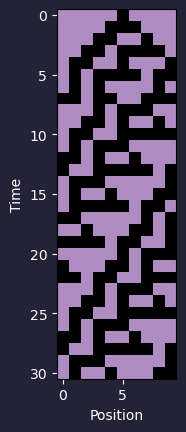

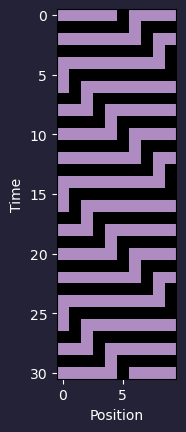

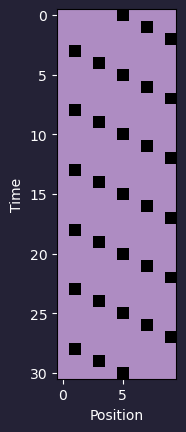

In [13]:
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
cah = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
init_state_nr=102
steps=30
#cah.set_state_reset(x_values[init_state_nr])
#ca.set_state_reset(x_values[init_state_nr])

ca.set_rule_number(RULE_NUMBER)
 
cah.set_rule_number(RULE_NUMBER)
ca.set_rule_number(RULE_NUMBER)

ca.step_multiple(steps)
cah.step_with_model(heuristic,(1,gridsize,1),steps)
figure,img=ca.render_state()
#figure.savefig("rule73_heur_ca.png", dpi=300, bbox_inches='tight')
figure,img=cah.render_state()
#figure.savefig("rule73_heur.png", dpi=300, bbox_inches='tight')
###################
aca=AnticipatoryCA(grid_size=gridsize,heuristic=heuristic , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
aca.set_rule_number(RULE_NUMBER)

#aca.set_state_reset(x_values[init_state_nr]) 
aca.weak_anticipation_step_multiple(steps)
figure,img=aca.render_state()
figure.savefig("rule73_heur_aca.png", dpi=300, bbox_inches='tight')

# Quantized Model

In [14]:

quantized_heuristic =get_model()

quantized_heuristic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
quantized_heuristic.summary()
early_stopping_callback = CustomCallback()
x_train=x_train.reshape(-1,MEMORY_CONSTANT*gridsize,1)
quantized_heuristic.fit(x_train, y_train, validation_data=(x_train, y_train), epochs=2
        , batch_size=2,callbacks=[early_stopping_callback])
 


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 10, 1, 1)          2         
                                                                 
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
 dense_2 (Dense)             (None, 10, 2)             4         
                                                                 
 wraparound1d_2 (Wraparound1  (None, 12, 2)            0         
 D)                                                              
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 10)            70        
                                                                 
 conv1d_6 (Conv1D)           (None, 10, 10)            110       
                                                      

# Quantization drastically decreases accuracy

In [15]:
def round_and_convert_to_int(x):
    return np.round(x).astype(np.int32)
for indx,layer in enumerate(quantized_heuristic.layers):
    if isinstance(layer, tf.keras.layers.Conv1D) or isinstance(layer, tf.keras.layers.Dense):
        weights, biases = layer.get_weights()
        layer.set_weights([round_and_convert_to_int(weights), round_and_convert_to_int(biases)])
        quantized_heuristic.layers[indx]=layer
         
print(quantized_heuristic.evaluate(x_train,y_train))
print(quantized_heuristic.weights)

24/24 [==============================] - 0s 1ms/step - loss: 0.6589 - accuracy: 0.6246
[0.6588704586029053, 0.6246093511581421]
[<tf.Variable 'conv1d_4/kernel:0' shape=(1, 1, 1) dtype=float32, numpy=array([[[2.]]], dtype=float32)>, <tf.Variable 'conv1d_4/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Variable 'dense_2/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[ 0., -2.]], dtype=float32)>, <tf.Variable 'dense_2/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>, <tf.Variable 'conv1d_5/kernel:0' shape=(3, 2, 10) dtype=float32, numpy=
array([[[ 0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.]],

       [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,  1.,  0.]],

       [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]],
      dtype=float32)>, <tf.Variable 'con

# Pruned Heuristic seems to have no effect

In [20]:

import tensorflow_model_optimization as tfmot

pruned_heuristic = tf.keras.Sequential()
pruned_heuristic.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
pruned_heuristic.add(Wraparound1D(padding=1))
pruned_heuristic.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True) )

pruned_heuristic.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same'))
 
pruned_heuristic.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

pruned_heuristic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
pruned_heuristic.summary()
pruned_model=pruned_heuristic
begin_step = 0
end_step = 5000  


pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
                                                               final_sparsity=0.87,
                                                               begin_step=0,
                                                               end_step=end_step)
}
 
#wraparound layer removed because its a custom layer
first_layers = pruned_model.layers[:1]
original_model = tf.keras.Sequential(pruned_model.layers[1:])


original_model_pruned = tfmot.sparsity.keras.prune_low_magnitude(original_model, **pruning_params)

 
pruned_heuristic_final = tf.keras.Sequential()
for layer in first_layers:
    pruned_heuristic_final.add(layer)
    
for layer in original_model_pruned.layers:
    pruned_heuristic_final.add(layer)
    
pruning_callback = tfmot.sparsity.keras.UpdatePruningStep()
pruned_heuristic_final.compile(optimizer='adam',loss=loss,metrics=['accuracy'] )

pruned_heuristic_final.build(input_shape=(None,gridsize,1))
pruned_heuristic.fit(x_train , y_train , validation_data=(x_val, y_val), epochs=1
        , batch_size=2,callbacks=[early_stopping_callback,pruning_callback])
pruned_heuristic_final.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d_4 (Wraparound1  (None, 12, 1)            0         
 D)                                                              
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 10)            40        
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 10)            110       
                                                                 
 dense_6 (Dense)             (None, 10, 2)             22        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
384/384 [==============================] - 1s 2ms/step - loss: 0.5724 - accuracy: 0.7479 - val_loss: 0.4566 - val_accuracy

# Adding gaussian noise to weights can result in better heuristics

In [21]:
memory_horizon=MEMORY_CONSTANT
heuristic = get_model()

heuristic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
heuristic.summary()
early_stopping_callback = CustomCallback()
x_train=x_train.reshape(-1,MEMORY_CONSTANT*gridsize,1)
heuristic.fit(x_train, y_train, validation_data=(x_train, y_train), epochs=2
        , batch_size=1,callbacks=[early_stopping_callback])
 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 10, 1, 1)          2         
                                                                 
 reshape_2 (Reshape)         (None, 10, 1)             0         
                                                                 
 dense_7 (Dense)             (None, 10, 2)             4         
                                                                 
 wraparound1d_5 (Wraparound1  (None, 12, 2)            0         
 D)                                                              
                                                                 
 conv1d_13 (Conv1D)          (None, 10, 10)            70        
                                                                 
 conv1d_14 (Conv1D)          (None, 10, 10)            110       
                                                      

In [23]:
noise_model=heuristic

conv_layer = noise_model.layers[-2]#[layer for layer in noise_model.layers if isinstance(layer, tf.keras.layers.Conv1D)]
acc=noise_model.evaluate(x_train,y_train)[1]
while(acc ==1 or acc <0.87):
  
    weights, biases = conv_layer.get_weights()
    noise = np.random.normal(0, 0.1, weights.shape)  
    weights_with_noise = weights + noise
    conv_layer.set_weights([weights_with_noise, biases])
    acc=noise_model.evaluate(x_test,y_test)[1]
        

print(acc)

4/4 [==============================] - 0s 2ms/step - loss: 0.4769 - accuracy: 0.8781
0.878125011920929


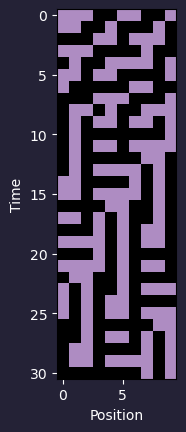

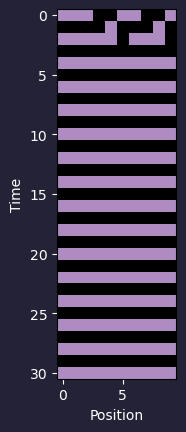

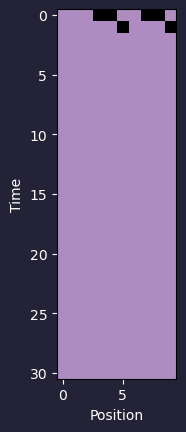

In [24]:
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=4)
cah = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
init_state_nr=102
steps=30
cah.set_state_reset(x_values[init_state_nr])
ca.set_state_reset(x_values[init_state_nr])
ca.set_rule_number(RULE_NUMBER)
 
cah.set_rule_number(RULE_NUMBER)
ca.set_rule_number(RULE_NUMBER)

ca.step_multiple(steps)
cah.step_with_model(noise_model,(1,gridsize,1),steps)
figure,img=ca.render_state()
figure.savefig("rule110_goodheur_ca.png", dpi=300, bbox_inches='tight')
figure,img=cah.render_state()
figure.savefig("rule110_goodheur.png", dpi=300, bbox_inches='tight')
###################
aca=AnticipatoryCA(grid_size=gridsize,heuristic=noise_model , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Default, memory_horizon=1)
aca.set_rule_number(RULE_NUMBER)
aca.set_state_reset(x_values[init_state_nr]) 
aca.weak_anticipation_step_multiple(steps)
figure,img=aca.render_state()


figure.savefig("rule110_goodheur_aca.png", dpi=300, bbox_inches='tight')

In [25]:
MEMORY_CONSTANT=2
 
sequence_length=MEMORY_CONSTANT*2
sequences= np.array(aca.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 
 
n = gridsize
np.random.shuffle(sequences)
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
y_sequence=sequences[:,MEMORY_CONSTANT*2]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
 
x_train = x_sequence
y_train_full= Y_val_onehot

 

Data generated


In [26]:
split_ratio = 0.25
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  

x_train,y_train,x_val,y_val,x_test,y_test=split_dataset(x_train_reshaped,y_train_full)

# with conv

In [28]:
num_filters=1
kernel_size = MEMORY_CONSTANT
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,MEMORY_CONSTANT,1  )))  
model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
                                 kernel_initializer=tf.keras.initializers.ones(), 
                                         bias_initializer=tf.keras.initializers.he_normal(),trainable=True,use_bias=True,
                                 activation="relu"
                                  ))

 
model.add(tf.keras.layers.Reshape((gridsize,1)))
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(gridsize, 3, activation='relu', padding='valid',  trainable=True) )

model.add(tf.keras.layers.Conv1D(gridsize, 1, activation='relu', padding='same'))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()

model.fit(x_train, y_train, 
          validation_data=(x_val, y_val)
          ,epochs=5
        , batch_size=1,callbacks=[early_stopping_callback]) 
print(f"test size {x_test.shape[0]}")
model.evaluate(x_test,y_test)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 10, 1, 1)          3         
                                                                 
 reshape_3 (Reshape)         (None, 10, 1)             0         
                                                                 
 dense_9 (Dense)             (None, 10, 2)             4         
                                                                 
 wraparound1d_6 (Wraparound1  (None, 12, 2)            0         
 D)                                                              
                                                                 
 conv1d_16 (Conv1D)          (None, 10, 10)            70        
                                                                 
 conv1d_17 (Conv1D)          (None, 10, 10)            110       
                                                     

[0.34189802408218384, 1.0]

# with recc

In [50]:
num_filters=1
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape, "x_val shape:", x_val.shape, "y_val shape:", y_val.shape, "x_test shape:", x_test.shape, "y_test shape:", y_test.shape)
kernel_size = MEMORY_CONSTANT
model = tf.keras.Sequential()

shape=(-1,gridsize*MEMORY_CONSTANT)
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize*MEMORY_CONSTANT,1   )))  

model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
                               kernel_initializer=tf.keras.initializers.Ones()))

model.add(tf.keras.layers.Reshape((gridsize,1)))
model.add(tf.keras.layers.Dense(units=2, activation="relu" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(gridsize, 3, activation='relu', padding='valid',  trainable=True) )

model.add(tf.keras.layers.Conv1D(gridsize, 1, activation='relu', padding='same'))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()

early_stopping_callback = CustomCallback()

model.fit(x_train.reshape(shape ), y_train, 
          validation_data=(x_val.reshape(shape), y_val)
          ,epochs=5
        , batch_size=1,callbacks=[early_stopping_callback]) 
print(f"test size {x_test.shape[0]}")
model.evaluate(x_test.reshape(shape ),y_test)

#print((x_train.reshape(shape )[0]))
#model.predict(x_train.reshape(shape )[0])

x_train shape: (768, 10, 1) y_train shape: (768, 10, 2) x_val shape: (128, 10, 1) y_val shape: (128, 10, 2) x_test shape: (128, 10, 1) y_test shape: (128, 10, 2)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 10, 1)             3         
                                                                 
 reshape_12 (Reshape)        (None, 10, 1)             0         
                                                                 
 dense_19 (Dense)            (None, 10, 2)             4         
                                                                 
 wraparound1d_11 (Wraparound  (None, 12, 2)            0         
 1D)                                                             
                                                                 
 conv1d_26 (Conv1D)          (None, 10, 10)            70        
                       

[0.3378736972808838, 1.0]

## Learning many


In [ ]:
set_seed()

MEMORY_CONSTANT=1
kernel_size=MEMORY_CONSTANT
sequence_length=MEMORY_CONSTANT*2
ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)


np.random.shuffle(x_values)
y_sequence= []
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]

tries=0
while i< 256:
    print(i)
    
    ca = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)
    ca.set_rule_number(i)
    sequences= np.array(ca.generate_training_data_sequences(x_values,sequence_length=sequence_length))
    np.random.shuffle(sequences)

    x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
    y_sequence=sequences[:,MEMORY_CONSTANT*2]
    x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)

    Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
    x_train = x_sequence   
    y_train= Y_val_onehot
    loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),                                                         tf.reshape(y, shape=(-1, num_classes)) ,from_logits=True)
    y_train_full= Y_val_onehot

    x_train_reshaped=[]
    for data_point in x_train:
        x_train_reshaped.append(np.transpose(data_point))
    x_train_reshaped=np.array(x_train_reshaped)  

    x_train,y_train,x_val,y_val,x_test,y_test=split_dataset(x_train_reshaped,y_train_full)
    memory_horizon=MEMORY_CONSTANT# is equal to 1
    model =get_model()
 
    early_stopping_callback = CustomCallback()

    history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10
            , batch_size=1,callbacks=[early_stopping_callback], verbose=True) 
    
    noise_model=model
    conv_layer = noise_model.layers[-2]
    acc=noise_model.evaluate(x_train,y_train)[1]
    while(acc ==1 or acc <0.90):

        weights, biases = conv_layer.get_weights()
        noise = np.random.normal(0, 0.1, weights.shape)  
        weights_with_noise = weights + noise
        conv_layer.set_weights([weights_with_noise, biases])
        acc=noise_model.evaluate(x_test,y_test)[1]
        

print(acc)
    eval=model.evaluate(x_test,y_test,verbose=False)

    if(eval[1] <1 and max(history.history["val_accuracy"])<1 and max(history.history["accuracy"])<1):
        print(eval[1])
        tries=tries+1
        i=i-1
        
   
    else:
        histories.append(history)
        print(i)
        tries=0
    if tries >5:
        tries=0
        failed.append(i)
        i=i+1
        print("skipped")
    i=i+1
